In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

data = pd.read_csv(r"C:\Users\gsanj\Downloads\public_dataset_updated.tar[1]\public_dataset\train\price_data\Feautures\AGI_merged.csv", parse_dates=['datetime'])

# Assuming your data is stored in `data` DataFrame
features = data[['open_x', 'MA_14_open', 'MA_30_open', 'MA_14_close', 
                 'price_diff_close_open', 'price_diff_high_low', 'volume_ratio', 
                 'lag_1_close', 'lag_7_close', 'lag_14_close', 'score']]
target = data['close_x']

# Handle missing values
features.fillna(0, inplace=True)  # Fill NaNs with 0

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale the data for regression models (Ridge, Lasso, etc.)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



C:\Users\gsanj\AppData\Local\Temp\ipykernel_32980\3549140576.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(0, inplace=True)  # Fill NaNs with 0


In [8]:
ridge = Ridge(alpha=1.0)
scores = cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Ridge CV MSE: {-scores.mean()}, Std Dev: {scores.std()}")
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

Ridge CV MSE: 1.0906340354726748e-06, Std Dev: 1.568042477823148e-06


In [9]:
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)


In [10]:
# Reshape data for LSTM input
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# LSTM Model
lstm = Sequential()
lstm.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm.add(Dropout(0.2))  # Dropout to prevent overfitting
lstm.add(Dense(1))

lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test))

y_pred_lstm = lstm.predict(X_test_lstm).flatten()


Epoch 1/50


C:\Users\gsanj\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - val_loss: 7.3266e-04
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0579e-04 - val_loss: 6.3850e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2999e-04 - val_loss: 5.0796e-04
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7630e-04 - val_loss: 4.3125e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9196e-04 - val_loss: 3.5112e-04
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1376e-04 - val_loss: 2.7100e-04
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2430e-04 - val_loss: 2.0409e-04
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0062e-04 - val_loss: 1.6484e-04
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6501e-04 - val_loss: 1.1874e-04
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3546e-04 - val_loss: 9.4104e-05
Epoch 12

In [12]:
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [13]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse}, MAE: {mae}, R²: {r2}")

# Evaluate all models
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_gb, "Gradient Boosting")
evaluate_model(y_test, y_pred_lstm, "LSTM")


Ridge Regression - RMSE: 0.00045160567358595556, MAE: 0.0003018026876714414, R²: 0.9997591445626954
Random Forest - RMSE: 0.0036186725168947894, MAE: 0.002312580784150046, R²: 0.9845354872752466
Gradient Boosting - RMSE: 0.002536925448388368, MAE: 0.0016087927886898742, R²: 0.9923993088405361
LSTM - RMSE: 0.005269450887721224, MAE: 0.003898104376902384, R²: 0.967207962761937


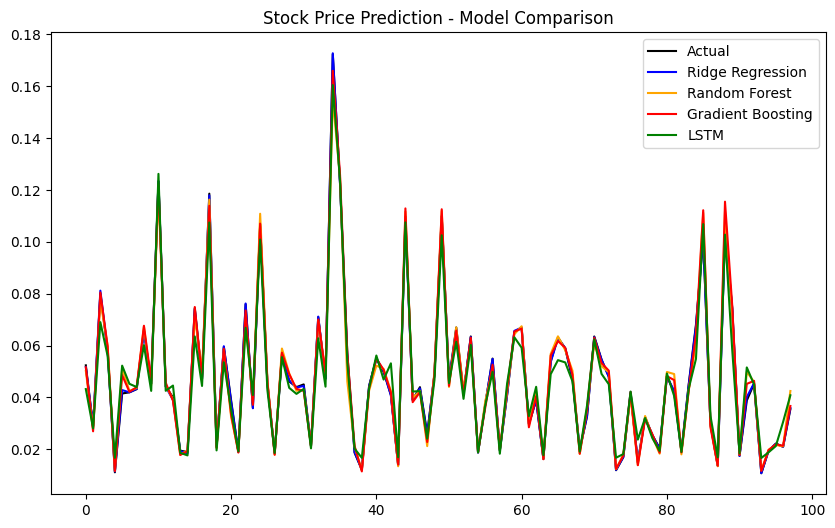

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='black')
plt.plot(y_pred_ridge, label='Ridge Regression', color='blue')
plt.plot(y_pred_rf, label='Random Forest', color='orange')
plt.plot(y_pred_gb, label='Gradient Boosting', color='red')
plt.plot(y_pred_lstm, label='LSTM', color='green')
plt.legend()
plt.title('Stock Price Prediction - Model Comparison')
plt.show()
